# TME 10: Split and Merge

In [1]:
### Usefull libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### Data
img_test = np.full((64,64),150,dtype=np.uint8)
img_test[32:48,16:16+32] = 100
img_test[8:24,40:56] = 50
angio = np.array(Image.open('img/angiogra.png'))
cam = np.array(Image.open('img/cameraman.png'))
muscle = np.array(Image.open('img/muscle.png'))
prisme = np.array(Image.open('img/prisme.png'))
seiche = np.array(Image.open('img/seiche.png'))

### Usefull functions
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def voisins(b,K):
    """ Blocstat*list[Blocstat]->list[Blocstat]
        retourne la liste des elements de K voisins de b
    """
    def estdans(x,y,a):
        """ int*int*Blocstat -> bool 
            Teste si (x,y) est dans a 
        """
        return x>=a[0] and y>=a[1] and x<a[0]+a[2] and y<a[1]+a[3]
    def sontvoisins(a,b):
        """ Blocstat**2 -> bool
            Teste si a et b sont voisins
        """
        if a[2]>b[2] and a[3]>b[3]:
            a,b=b,a
        x,y = a[0]+a[2]//2,a[1]+a[3]//2
        return estdans(x+a[2],y,b) or estdans(x-a[2],y,b) or estdans(x,y+a[3],b) or estdans(x,y-a[3],b)
    N = []
    for n in K:
        if sontvoisins(b,n):
            N.append(n)
    return N


## Exercice 1

### Question 1
Écrire la fonction récursive ``split()`` vue en TD. Elle prend en entrée l'image, une région, un prédicat, et un nombre variable d'arguments. La région est de type formel Python ```Bloc``` défini par :
```python
type Bloc = tuple[int**4]
```
La fonction ``split()`` retourne un arbre 4-aire de type formel Python, défini récursivement par:
```python
type 4-aire = list[(4-aire**4|Bloc)] 
```
Le prédicat est une fonction Python de signature:
```python
Array*Bloc*...->bool
```
Elle peut prendre un nombre variable de paramètres qui correspond aux paramètres du prédicat.


In [2]:
def split(I,reg,pred,*args):
    """ Array*Bloc*(Array*Bloc*...->bool)*... -> 4-aire
        Découpage de I en arbre 4-aire sur un critère d'écart-type minimal
    """
    x1,y1,x2,y2=reg
    if pred(I,reg,args) and (x2-x1)>4 and (y2-y1)>4:
        no=split(I,(x1,y1,x1+(x2-x1)//2,y1+(y2-y1)//2),pred,args) 
        ne=split(I,(x1+(x2-x1)//2+1,y1,x2,y1+(y2-y1)//2),pred,args)
        so=split(I,(x1,y1+(y2-y1)//2+1,x1+(x2-x1)//2,y2),pred,args)
        se=split(I,(x1+(x2-x1)//2+1,y1+(y2-y1)//2+1,x2,y2),pred,args)
        return [no,ne,so,se]
    else:
        return [(x1,y1,x2,y2)]

### Question 2
Écrire la fonction ```predsplit1(I,B,*args)``` de signature :
```python
Array*Bloc*... -> bool
```
qui retourne True si l'écart-type de l'image ``I`` calculé sur la région ``B`` est plus grand que la valeur du premier argument de ``*args`` (on y accède simplement par ``*args[0]``).

In [3]:
def predsplit1(I,reg,*args):
    """ Array*Bloc*... -> bool
    """ 
    region = I[reg[0]:reg[2] , reg[1]:reg[3]]
    ecarttype=np.std(region)
    return ecarttype > args[0]

### Question 3
Écrire la fonction ``splitprof(L)`` qui réaliste un parcours (récursif) en profondeur de l'arbre 4-aire passé en paramètre. La fonction retourne la liste des feuilles de ``L``, soit une liste de bloc.

In [4]:
def splitprof(L):
    """ 4-aire -> list[Bloc]"""
   
    feuilles=list()
    if isinstance(L,tuple):
        feuilles.append(L)
        
    else:
        for i in range(len(L)):
            feuilles+=splitprof(L[i])
    return feuilles

In [5]:
a=[(1,2),[(3,4),(5,6)]]
splitprof(a)

[(1, 2), (3, 4), (5, 6)]

### Question 4
Tester vos codes sur l'image test ``img_test`` vue en TD. Imprimer la valeur retournée par ``split()`` ainsi que celle retournée par ``profsplit()``. 

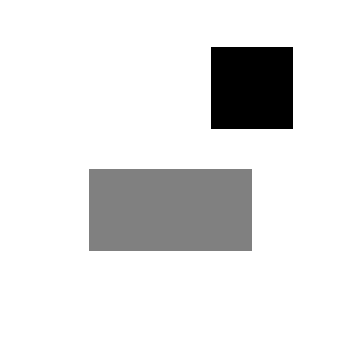

[[(0, 0, 31, 31)],
 [[(32, 0, 47, 15)],
  [(48, 0, 63, 15)],
  [(32, 16, 47, 31)],
  [(48, 16, 63, 31)]],
 [[[(0, 32, 7, 39)], [(8, 32, 15, 39)], [(0, 40, 7, 47)], [(8, 40, 15, 47)]],
  [[(16, 32, 23, 39)],
   [(24, 32, 31, 39)],
   [(16, 40, 23, 47)],
   [(24, 40, 31, 47)]],
  [[(0, 48, 7, 55)], [(8, 48, 15, 55)], [(0, 56, 7, 63)], [(8, 56, 15, 63)]],
  [[(16, 48, 23, 55)],
   [(24, 48, 31, 55)],
   [(16, 56, 23, 63)],
   [(24, 56, 31, 63)]]],
 [[(32, 32, 47, 47)],
  [(48, 32, 63, 47)],
  [(32, 48, 47, 63)],
  [(48, 48, 63, 63)]]]

In [6]:
#valeur retournée par split()
imshow(img_test)
split(img_test,(0,0,63,63),predsplit1,[2])


In [7]:
#valeur retournée par splitprof()
LL= splitprof(split(img_test,(0,0,63,63),predsplit1,[1]))
print(LL)

[(0, 0, 31, 31), (32, 0, 47, 15), (48, 0, 63, 15), (32, 16, 47, 31), (48, 16, 63, 31), (0, 32, 7, 39), (8, 32, 15, 39), (0, 40, 7, 47), (8, 40, 15, 47), (16, 32, 23, 39), (24, 32, 31, 39), (16, 40, 23, 47), (24, 40, 31, 47), (0, 48, 7, 55), (8, 48, 15, 55), (0, 56, 7, 63), (8, 56, 15, 63), (16, 48, 23, 55), (24, 48, 31, 55), (16, 56, 23, 63), (24, 56, 31, 63), (32, 32, 47, 47), (48, 32, 63, 47), (32, 48, 47, 63), (48, 48, 63, 63)]


### Question 4
Écrire la fonction ```splitdraw(L,I)``` qui prend en paramètre une liste de bloc et une image et retourne une image dont les bords de chaque éléments de ``L`` ont été dessiné en rouge. Indication: l'image retournée est une hypermatrice de dimension 3, la troisième dimension a une taille de 3 et correspond aux composantes rouge, verte et bleue d'une image RGB. Tester son bon fonctionnement sur l'exemple précédent.

In [8]:
def splitdraw(LL,I):
    """ list[Bloc]*Array -> Array
        parcours de la liste dessin des régions 
    """
    
    #l'image en RGB
    I_RGB = np.stack((I,)*3, axis=-1)
    for i in LL:
        I_RGB[i[0]:i[2],i[1]]=[255,0,0] # dessine la ligne haute
        I_RGB[i[0]:i[2],i[3]]=[255,0,0] # dessine la ligne bas
        I_RGB[i[0],i[1]:i[3]]=[255,0,0] # dessine la ligne gauche
        I_RGB[i[2],i[1]:i[3]]=[255,0,0] #dessine la ligne droite
        I_RGB[i[2],i[3]]=[255,0,0]      # dessine le point de l'intersection des lignes droites avec celles du bas
    return I_RGB

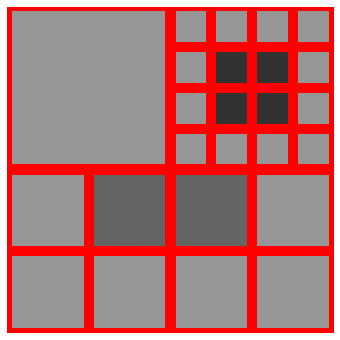

(64, 64)


In [9]:
LL= splitprof(split(img_test,(0,0,63,63),predsplit1,[1]))
imshow(splitdraw(LL,img_test))
print(img_test.shape)

### Question 5
Ajouter un bruit gaussien sur l'image ``img_test`` d'écart-type 5. Recalculer un découpage 4-aire sur l'image bruitée en ajustant le seuil de façon à obtenir le même résultat que dans la question précédente. Quelle valeur de seuil a-t-il fallut choisir ? Cela vous semble-t-il cohérent ?

Indication: utiliser la fonction Numpy ``random.randn()`` qui génère des valeurs aléatoires tirées selon une loi normale (loi gaussienne de moyenne nulle et de variance 1). Pour obtenir des réalisations d'une gaussienne d'écart type $\sigma$, il suffit de faire des tirages d'une loi normale, multipliés par $\sigma$. 

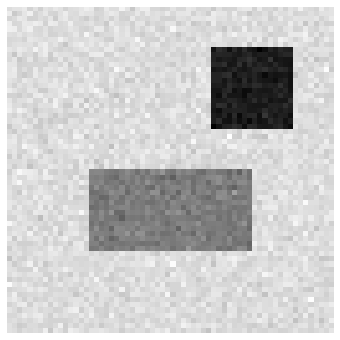

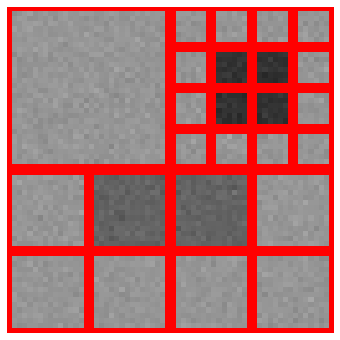

In [10]:
from numpy import random

def addGaussian(img,sigma):
    gaussian_img=np.zeros((img.shape))
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            gaussian_img[x,y]=img[x,y]+(random.randn()*sigma)
    return gaussian_img.astype(int)
            
gaussian_img_test=addGaussian(img_test,5)
imshow(gaussian_img_test)
LL= splitprof(split(gaussian_img_test,(0,0,63,63),predsplit1,[6]))
imshow(splitdraw(LL,gaussian_img_test))

### Réponses aux deux questions: Quelle valeur de seuil a-t-il fallut choisir ? Cela vous semble-t-il cohérent ?

# Exercice 2
Question 1:
Expérimenter l'algorithme de split sur les 4 images naturelles fournie. Pour chaque image essayer de trouver le seuil qui vous semble visuellement le meilleur. Afficher le nombre de bloc obtenus après découpage.

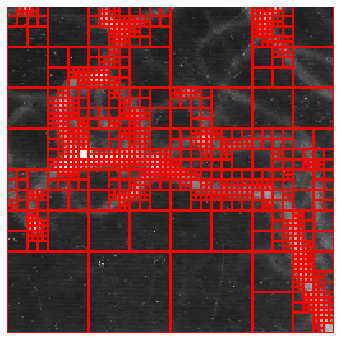

916


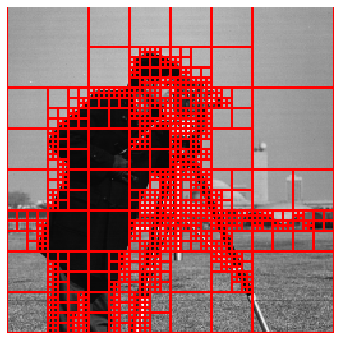

928


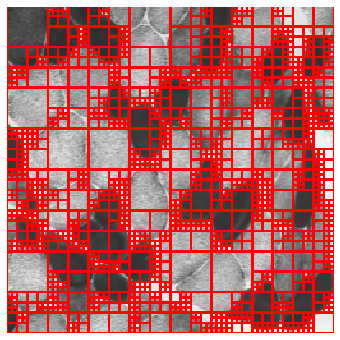

1387


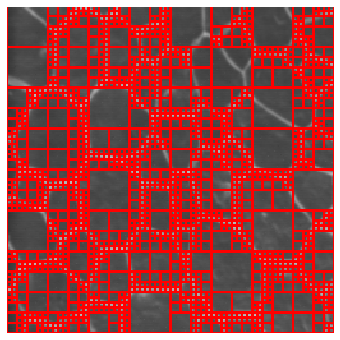

1567


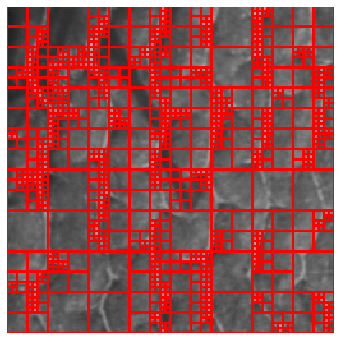

1021


In [21]:
LL= splitprof(split(angio,(0,0,angio.shape[0]-1,angio.shape[1]-1),predsplit1,16))
imshow(splitdraw(LL,angio))
print(len(LL))

LL= splitprof(split(cam,(0,0,cam.shape[0]-1,cam.shape[1]-1),predsplit1,25))
imshow(splitdraw(LL,cam))
print(len(LL))

LL= splitprof(split(muscle,(0,0,muscle.shape[0]-1,muscle.shape[1]-1),predsplit1,25))
imshow(splitdraw(LL,muscle))
print(len(LL))

LL= splitprof(split(prisme,(0,0,prisme.shape[0]-1,prisme.shape[1]-1),predsplit1,18))
imshow(splitdraw(LL,prisme))
print(len(LL))

LL= splitprof(split(seiche,(0,0,seiche.shape[0]-1,seiche.shape[1]-1),predsplit1,15))
imshow(splitdraw(LL,seiche))
print(len(LL))

## Exercice 3
### Question 1
Modifier la fonction ``splitprof(L)`` pour en faire une fonction ``splitprofstat(L,I)`` qui rend une liste de feuilles de l'arbre 4-aire ``L`` et telle que chaque élément de cette liste, de type ``Bloc``, est enrichi de trois scalaires, le premier étant la taille, le second la moyenne et la troisième la variance des valeurs de pixels du bloc dans l'image ``I``. Cette fonction rend alors une liste dont les éléments ont pour type formel:
```python
type Blocstat = tuple[int**4,int,float**2]
```
Les quatre premières valeurs sont celles du type ``Bloc``, la cinquième est la taille du bloc (en nombre de pixels) et les deux dernières correspondent à la moyenne et la variance calculées sur la région.


In [38]:
# Nous avons simplifier la fonction splitprofstats en faisant d'abord une fonction 
#qui renvoie la taille, la moyenne et la variance
def calculeElements(L,I):
    size=(L[2]-L[0]+1)*(L[3]-L[1]+1)
    mean=np.mean(I[L[0]:L[2],L[1]:L[3]])
    var=np.var(I[L[0]:L[2],L[1]:L[3]])
    return(size,mean,var)

def splitprofstats(L,I):
    """ 4-aire*Array -> list[Blocstat] """
    feuilles=list()
    if isinstance(L,tuple):
        feuilles.append(L+calculeElements(L,I))
        
    else:
        for i in range(len(L)):
            feuilles+=splitprofstats(L[i],I)
    return feuilles

print(splitprofstats(split(img_test,(0,0,63,63),predsplit1,[1]),img_test))
print(splitprofstats(split(img_test,(0,0,63,63),predsplit1,[1]),gaussian_img_test))
    

[(0, 0, 31, 31, 1024, 150.0, 0.0), (32, 0, 47, 15, 256, 150.0, 0.0), (48, 0, 63, 15, 256, 150.0, 0.0), (32, 16, 47, 31, 256, 100.0, 0.0), (48, 16, 63, 31, 256, 150.0, 0.0), (0, 32, 7, 39, 64, 150.0, 0.0), (8, 32, 15, 39, 64, 150.0, 0.0), (0, 40, 7, 47, 64, 150.0, 0.0), (8, 40, 15, 47, 64, 50.0, 0.0), (16, 32, 23, 39, 64, 150.0, 0.0), (24, 32, 31, 39, 64, 150.0, 0.0), (16, 40, 23, 47, 64, 50.0, 0.0), (24, 40, 31, 47, 64, 150.0, 0.0), (0, 48, 7, 55, 64, 150.0, 0.0), (8, 48, 15, 55, 64, 50.0, 0.0), (0, 56, 7, 63, 64, 150.0, 0.0), (8, 56, 15, 63, 64, 150.0, 0.0), (16, 48, 23, 55, 64, 50.0, 0.0), (24, 48, 31, 55, 64, 150.0, 0.0), (16, 56, 23, 63, 64, 150.0, 0.0), (24, 56, 31, 63, 64, 150.0, 0.0), (32, 32, 47, 47, 256, 100.0, 0.0), (48, 32, 63, 47, 256, 150.0, 0.0), (32, 48, 47, 63, 256, 150.0, 0.0), (48, 48, 63, 63, 256, 150.0, 0.0)]
[(0, 0, 31, 31, 1024, 149.7440166493236, 26.406897081928832), (32, 0, 47, 15, 256, 149.96, 29.380622222222218), (48, 0, 63, 15, 256, 149.43555555555557, 21.756

### Question 2
Dans la suite du TME, on considère le type formel:
```python
type Region = list[Blocstat]
```
Une région, comme vu au TME, est donc une liste de blocs. Écrire le prédicat de fusion ``predmerge(b,R,*args)`` vu en TD. Cette fonction retourne ```True``` si le bloc ``b`` doit fusionner dans la région ``R``. Si telle est le cas, alors le premier élément de la liste ``R`` voit ses statistiques modifiées: elles décrivent celles de l'ensemble des blocs de la région ainsi fusionnée.

In [39]:
def predmerge(b,R,*args):
    """ Blocstat*Region*... -> bool 
        Si fusion, R[0] est modifié
    """    
    n1=b[4] #taille du bloc b
    n2=R[0][4] #taille du premier élément de la liste R
    
    #calcul des nouvelles stats 
    n=n1+n2 #taille 
    mean=(1/n)*(n1*b[5]+n2*R[0][5]) 
    var=(1/n)*((b[6]+b[5]**2)*n1+(R[0][6]+R[0][5]**2)*n2)-(mean**2)
    
    
    if var<args[0]:
        R[0]=(R[0][0],R[0][1],R[0][2],R[0][3],n,mean,var)
        return R,True
    else:
        return R,False


### Question 3
À l'aide de `predmerge()` et de la fonction `voisins()`, donnée au début du notebook, implémenter la fonction de fusion vues en TD (Exercice 3.3).

Rappels sur les listes Python:
- Initialisation: `L = []`  (liste vide),
- Ajout de l'élément `a` à la liste `L`: `L.append(a)`,
- Suppression du même élément: `L.remove(a)`,
- Accès aux éléments d'une liste: identique aux tableaux Numpy.

In [40]:
def merge(S,I,pred,*args):
    """ 4-aire*Array*(Blocstat*Region*...->bool) -> list[Region]
        Fusionne les feuilles de S en une liste de régions
    """
    L=[]
    K=splitprofstats(S,I)
    while K != []:
        b=K[0]
        R=[b]
        K.remove(b)
        N=voisins(b,K)
        for bn in N:
            R,canMerge=pred(bn,R,args[0])
            if (bn in K and canMerge):
                R.append(bn)
                K.remove(bn)
                N+=voisins(bn,K)
                
        L.append(R)
    return L


### Question 4
Faire la mise au point des fonctions précédentes à l'aide de l'image img_test.

In [41]:
img_test_merged=(merge(split(img_test,(0,0,63,63),predsplit1,[2]),img_test,predmerge,2))
print(img_test_merged)


[[(0, 0, 31, 31, 9280, 150.00000000000003, 3.637978807091713e-12), (8, 32, 15, 39, 64, 150.0, 0.0), (0, 32, 7, 39, 64, 150.0, 0.0), (0, 40, 7, 47, 64, 150.0, 0.0), (16, 32, 23, 39, 64, 150.0, 0.0), (24, 32, 31, 39, 64, 150.0, 0.0), (24, 40, 31, 47, 64, 150.0, 0.0), (0, 48, 7, 55, 64, 150.0, 0.0), (8, 56, 15, 63, 64, 150.0, 0.0), (24, 48, 31, 55, 64, 150.0, 0.0), (0, 56, 7, 63, 64, 150.0, 0.0), (16, 56, 23, 63, 64, 150.0, 0.0), (24, 56, 31, 63, 64, 150.0, 0.0), (48, 32, 63, 47, 256, 150.0, 0.0), (32, 48, 47, 63, 256, 150.0, 0.0), (48, 48, 63, 63, 256, 150.0, 0.0), (32, 0, 47, 15, 256, 150.0, 0.0), (48, 0, 63, 15, 256, 150.0, 0.0), (48, 16, 63, 31, 256, 150.0, 0.0)], [(32, 16, 47, 31, 512, 100.0, 0.0), (32, 32, 47, 47, 256, 100.0, 0.0)], [(8, 40, 15, 47, 192, 50.0, 0.0), (16, 40, 23, 47, 64, 50.0, 0.0), (16, 48, 23, 55, 64, 50.0, 0.0)], [(8, 48, 15, 55, 64, 50.0, 0.0)]]


### Question 5
Écrire une fonction ``regions(LR,shape)`` qui prend une liste de régions telle que rendu par la fonction ``merge()`` et rend une image des régions. Chaque région sera colorée avec le niveau de gris correspondant à la moyenne de la région. Le paramètre ``shape`` donne la taille de l'image à produire. Tester la fonction sur l'exemple précédent.

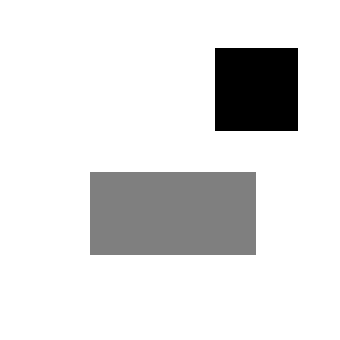

In [42]:
def regions(LR,shape):
    """ list[Region] -> Array """
    
    #img région de taille shape
    img_region=np.zeros(shape)
    
    for reg in LR:
        for zone in reg:
            img_region[zone[0]:zone[2]+1,zone[1]:zone[3]+1]=reg[0][5]
    return img_region


imshow(regions(img_test_merged,(63,63)))

## Exercice 4: expérimentation
### Question 1
Tester la fonction ``merge()`` sur les images ``angio``, ``cam``, ``muscle``, ``prisme`` et ``seiche``.

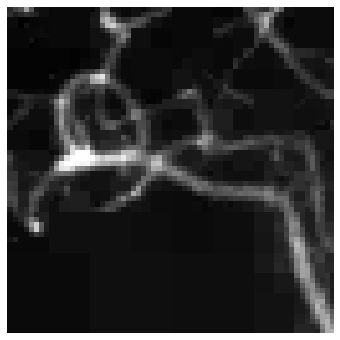

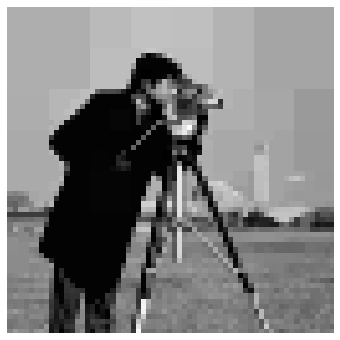

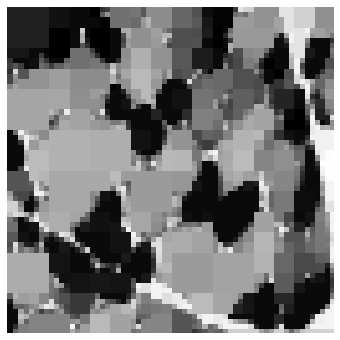

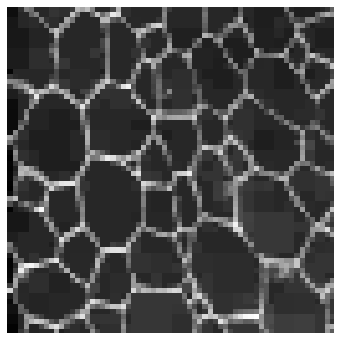

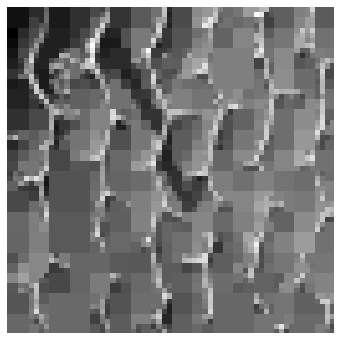

In [43]:
#Nous avons définie cette fonction pour faciliter les tests sur les images
def displayMerge(img,predsplit,predmerge,sigma):
    img_merged=(merge(split(img,(0,0,img.shape[0],img.shape[1]),predsplit,[sigma]),img,predmerge,sigma))
    imshow(regions(img_merged,img.shape))
    
displayMerge(angio,predsplit1,predmerge,10)  #test de l'image angio
displayMerge(cam,predsplit1,predmerge,8)     #test de l'image angio
displayMerge(muscle,predsplit1,predmerge,25) #test de l'image angio
displayMerge(prisme,predsplit1,predmerge,11) #test de l'image angio
displayMerge(seiche,predsplit1,predmerge,12) #test de l'image angio

### Question 2
La fusion dépend de la façon dont on visite les régions. On peut alors faire un tri des feuilles de l'arbre 4-aire, par exemple, des blocs les plus gros aux plus petits, ou le contraire (utiliser la fonction Python ``sorted()``). La même question peut se poser lorsqu'on calcule l'ensemble des voisins de la région que l'on fusionne. Faut-il les trier ? Si oui, selon quel critère ? leur taille ? leur proximité ? Evidemment il n'y a pas de réponse universelle mais adaptée à chaque type de problème. Faites quelques tests pour voir l'influence de ces tris sur le résultat de la fusion.

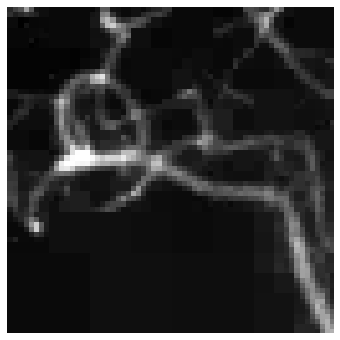

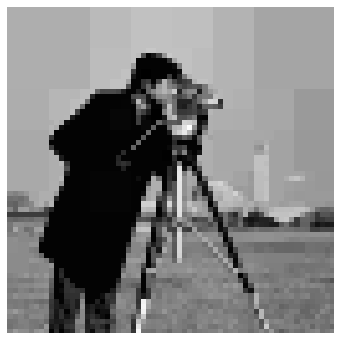

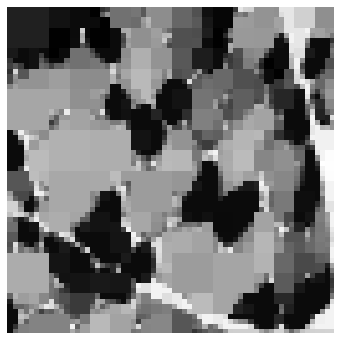

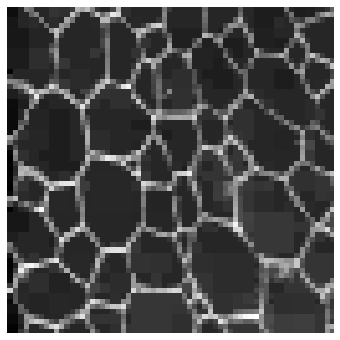

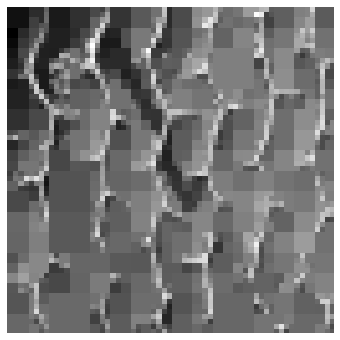

In [48]:
from operator import itemgetter, attrgetter  #trier rapidement en utilisant itemgetter avec sorted
#fusion en triant les feuilles selon la taille croissant:

def mergeSortedTaille(S,I,pred,*args):
    """ 4-aire*Array*(Blocstat*Region*...->bool) -> list[Region]
        Fusionne les feuilles de S en une liste de régions
    """
    L=[]
    K=splitprofstats(S,I)
    K=sorted(K,key=itemgetter(4)) #trier selon le critère taille
    
    while K != []:
        b=K[0]
        R=[b]
        K.remove(b)
        N=voisins(b,K)
        for bn in N:
            R,canMerge=pred(bn,R,args[0])
            if (bn in K and canMerge):
                R.append(bn)
                K.remove(bn)
                N+=voisins(bn,K)
                
        L.append(R)
    return L

def displayMergeTaille(img,predsplit,predmerge,sigma):
    img_merged=(mergeSortedTaille(split(img,(0,0,img.shape[0],img.shape[1]),predsplit,[sigma]),img,predmerge,sigma))
    imshow(regions(img_merged,img.shape))
    
displayMergeTaille(angio,predsplit1,predmerge,10)  #test de l'image angio
displayMergeTaille(cam,predsplit1,predmerge,8)     #test de l'image angio
displayMergeTaille(muscle,predsplit1,predmerge,25) #test de l'image angio
displayMergeTaille(prisme,predsplit1,predmerge,11) #test de l'image angio
displayMergeTaille(seiche,predsplit1,predmerge,12) #test de l'image angio


In [ ]:
#Nous avons fait la fusion en triant les feuilles selon la taille (croissant)

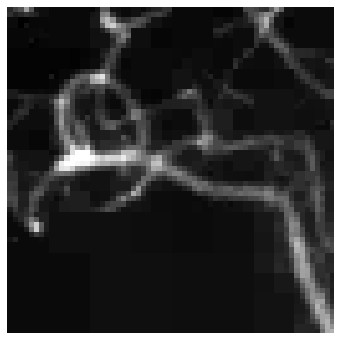

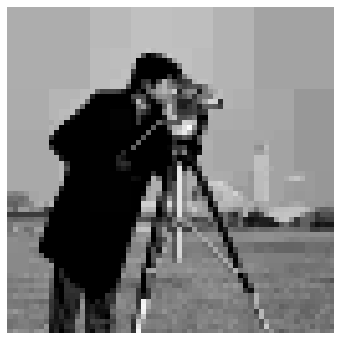

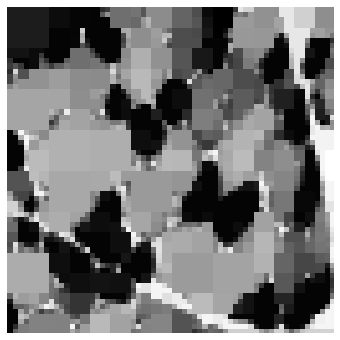

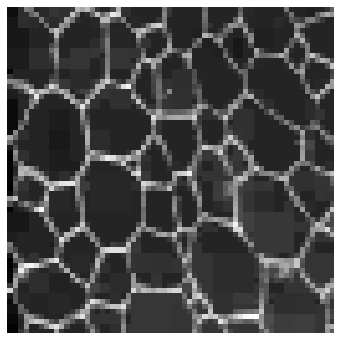

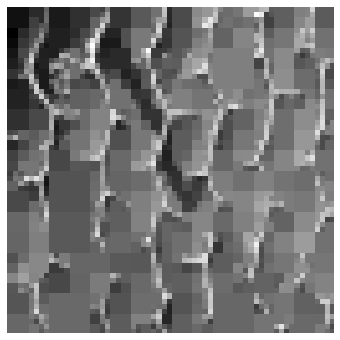

In [49]:
from operator import itemgetter, attrgetter  #trier rapidement en utilisant itemgetter avec sorted
#fusion en triant les feuilles selon la taille selon l'ordre décroissant:

def mergeSortedTailleReverse(S,I,pred,*args):
    """ 4-aire*Array*(Blocstat*Region*...->bool) -> list[Region]
        Fusionne les feuilles de S en une liste de régions
    """
    L=[]
    K=splitprofstats(S,I)
    K=sorted(K,key=itemgetter(4),reverse=True) #trier selon le critère taille
    
    while K != []:
        b=K[0]
        R=[b]
        K.remove(b)
        N=voisins(b,K)
        for bn in N:
            R,canMerge=pred(bn,R,args[0])
            if (bn in K and canMerge):
                R.append(bn)
                K.remove(bn)
                N+=voisins(bn,K)
                
        L.append(R)
    return L

def displayMergeTailleReverse(img,predsplit,predmerge,sigma):
    img_merged=(mergeSortedTailleReverse(split(img,(0,0,img.shape[0],img.shape[1]),predsplit,[sigma]),img,predmerge,sigma))
    imshow(regions(img_merged,img.shape))
    
displayMergeTailleReverse(angio,predsplit1,predmerge,10)  #test de l'image angio
displayMergeTailleReverse(cam,predsplit1,predmerge,8)     #test de l'image angio
displayMergeTailleReverse(muscle,predsplit1,predmerge,25) #test de l'image angio
displayMergeTailleReverse(prisme,predsplit1,predmerge,11) #test de l'image angio
displayMergeTailleReverse(seiche,predsplit1,predmerge,12) #test de l'image angio
